In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples

random_state = 1000

In [2]:
df = pd.read_csv('../data/rock_data.csv')
df.columns

Index(['Sample ID', 'Rock ID', 'Class', 'Orientation', 'Perimeter', 'Area',
       'Axis Major Length', 'Axis Minor Length', 'Mean Height',
       'Median Height', 'Max Height', 'STD Height', 'Mean Gradient',
       'STD Gradient', 'Gradient at Max', 'Weighted Hu Moment 1',
       'Weighted Hu Moment 2', 'Weighted Hu Moment 3', 'Weighted Hu Moment 4'],
      dtype='object')

In [3]:
# handle missing values
if df.isnull().values.any():
    df.fillna(df.mean(), inplace=True)
    print('Missing values filled with mean.')

In [4]:
print(df['Area'][df['Class']==12].mean())
print(df['Area'][df['Class']==58].mean())
print(df['Area'][df['Class']==34].mean())

360.46310432569976
482.16776315789474
612.5852417302799


In [5]:
# normalize features
df.iloc[:,3:] = df.iloc[:,3:].apply(zscore)

In [6]:
# detect and remove outliers
for column in df.columns[3:]:
    n_outliers = sum(abs(zscore(df[column]))>3) 
    df = df.loc[abs(zscore(df[column]))<=3]
    if n_outliers > 0:
        print(f'Remove {n_outliers} outliers of {column}')

Remove 13 outliers of Perimeter
Remove 11 outliers of Area
Remove 9 outliers of Axis Major Length
Remove 1 outliers of Axis Minor Length
Remove 7 outliers of Mean Height
Remove 6 outliers of Median Height
Remove 5 outliers of Max Height
Remove 4 outliers of STD Height
Remove 7 outliers of Mean Gradient
Remove 8 outliers of STD Gradient
Remove 18 outliers of Gradient at Max
Remove 11 outliers of Weighted Hu Moment 1
Remove 24 outliers of Weighted Hu Moment 2
Remove 19 outliers of Weighted Hu Moment 3
Remove 13 outliers of Weighted Hu Moment 4


For ground-truth clustering, the average silhouette_score = 0.047562721403937365


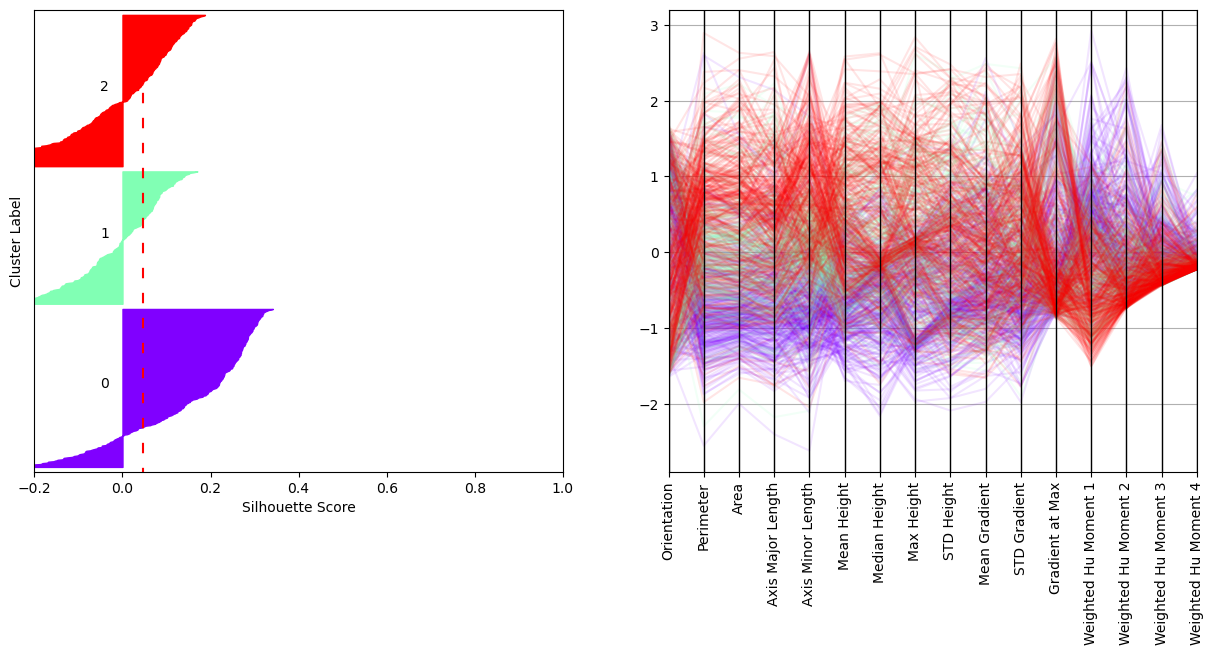

In [7]:
n_clusters = 3
X = df.iloc[:,3:].to_numpy(dtype=float)
df_clustered = df.iloc[:,3:].copy()

def map_class_values(x):
    mapping = {12: 0, 58: 1, 34: 2}
    return mapping.get(x,None)

actual_class = np.vectorize(map_class_values)(df['Class'].values)
df_clustered['cluster'] = actual_class
kmeans_sil = silhouette_score(X, actual_class)
samps_sil = silhouette_samples(X, actual_class)

print(f"For ground-truth clustering, the average silhouette_score = {kmeans_sil}")

fig, axs = subplots(nrows=1, ncols=2, figsize=(15,6))

c_map = cm.rainbow(np.linspace(0, 1, n_clusters))

y_lower = 10
for i in range(n_clusters):
    cluster_sil = np.sort(samps_sil[actual_class == i])
    y_upper = y_lower + cluster_sil.shape[0]

    axs[0].fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil, color=c_map[i])

    axs[0].set_xlim([-0.2, 1])
    axs[0].set_ylim([0, len(X) + (n_clusters + 1) * 10])
    axs[0].text(-0.05, y_lower + 0.5 * cluster_sil.shape[0], str(i))

    y_lower = y_upper + 10

axs[0].set_xlabel("Silhouette Score")
axs[0].set_ylabel("Cluster Label")

axs[0].axvline(x=kmeans_sil, color="red", linestyle=(3,(5,7)))

axs[0].set_yticks([])
axs[0].set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

pd.plotting.parallel_coordinates(df_clustered, 'cluster', ax=axs[1], color=c_map, alpha=0.1)
xticks(rotation=90)
axs[1].legend().set_visible(False)

show()

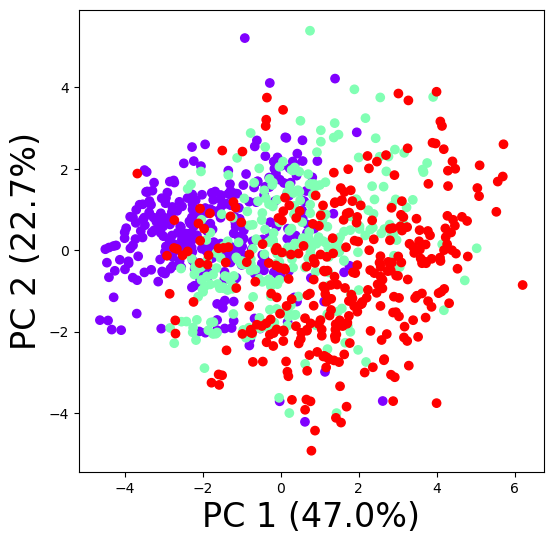

In [8]:
pca = PCA(n_components=2)
components = pca.fit_transform(X)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig, axs = subplots(nrows=1, ncols=1, figsize=(6,6))

c_map = cm.rainbow(np.linspace(0, 1, n_clusters))
axs.scatter(components[:,0], components[:,1], color=df_clustered['cluster'].map(lambda x: c_map[x]))
axs.set_xlabel(labels['0'], fontsize=24)
axs.set_ylabel(labels['1'], fontsize=24)

show()

In [9]:
pca.components_

array([[ 0.01020371,  0.25787764,  0.24956431,  0.24138117,  0.24228789,
         0.37053061,  0.32814858,  0.36127246,  0.35262376,  0.25307777,
         0.29616488,  0.00995403, -0.3006335 , -0.07653547, -0.07644172,
        -0.01913237],
       [ 0.00719941, -0.42203552, -0.42733558, -0.38217947, -0.43697911,
         0.11233159,  0.12407798,  0.12540252,  0.22659203,  0.37009458,
         0.19759365,  0.02744089, -0.14652395, -0.0873192 , -0.03427984,
        -0.00937336]])